In [ ]:
pip install yfinance


In [ ]:
import yfinance as yf
import pandas as pd

def get_historical_stock_data(ticker):
    try:

        stock_data = yf.download(ticker)


        print(f"Historical stock data for {ticker} from earliest available date to current date:")
        print(stock_data)


        stock_data.to_csv(f"{ticker}_historical_data.csv")

    except Exception as e:
        print(f"Error retrieving data for {ticker}: {str(e)}")

get_historical_stock_data("TATASTEEL.NS")


[*********************100%%**********************]  1 of 1 completed

Historical stock data for TATASTEEL.NS from earliest available date to current date:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1996-01-01   11.172855   11.214964   11.035300   11.186892    5.308654   
1996-01-02   11.172855   11.214964   10.951082   10.979155    5.210076   
1996-01-03   10.979155   11.229000   10.951082   10.981962    5.211407   
1996-01-04   10.807913   10.807913   10.386825   10.633863    5.046220   
1996-01-05   10.504730   10.555260   10.316644   10.423319    4.946307   
...                ...         ...         ...         ...         ...   
2024-03-01  143.000000  150.649994  143.000000  149.949997  149.949997   
2024-03-04  154.899994  154.899994  151.050003  153.100006  153.100006   
2024-03-05  153.199997  154.000000  150.750000  151.850006  151.850006   
2024-03-06  151.800003  152.649994  147.899994  151.600006  151.600006   
2024-03-07  152.399994  159

In [ ]:

df=pd.read_csv("/content/TATASTEEL.NS_historical_data.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,11.172855,11.214964,11.035300,11.186892,5.308654,10242229
1,1996-01-02,11.172855,11.214964,10.951082,10.979155,5.210076,16954313
2,1996-01-03,10.979155,11.229000,10.951082,10.981962,5.211407,13514114
3,1996-01-04,10.807913,10.807913,10.386825,10.633863,5.046220,34785820
4,1996-01-05,10.504730,10.555260,10.316644,10.423319,4.946307,30138033
...,...,...,...,...,...,...,...
7080,2024-03-01,143.000000,150.649994,143.000000,149.949997,149.949997,123709943
7081,2024-03-04,154.899994,154.899994,151.050003,153.100006,153.100006,67577785
7082,2024-03-05,153.199997,154.000000,150.750000,151.850006,151.850006,37165490
7083,2024-03-06,151.800003,152.649994,147.899994,151.600006,151.600006,51782444


In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Attention, Concatenate, Flatten

In [ ]:
# Create sequences for CNN
sequence_length = 10
X_cnn = []

for i in range(len(df) - sequence_length):
    X_cnn.append(df['Close'].values[i:i+sequence_length])

X_cnn = np.array(X_cnn)

In [ ]:
# Create sequences for BiLSTM
sequence_length_lstm = 10
X_lstm = []

for i in range(len(df) - sequence_length_lstm):
    X_lstm.append(df['Close'].values[i:i+sequence_length_lstm])

X_lstm = np.array(X_lstm)

In [ ]:
# Create target variable
y = df['Close'][sequence_length_lstm:].values

# Check the lengths
print(len(X_cnn), len(X_lstm), len(y))

# Ensure the lengths are the same
min_length = min(len(X_cnn), len(X_lstm), len(y))
X_cnn = X_cnn[:min_length]
X_lstm = X_lstm[:min_length]
y = y[:min_length]

# Check the lengths again
print(len(X_cnn), len(X_lstm), len(y))


7075 7075 7075
7075 7075 7075


In [ ]:

# Split the data into training and testing sets
cnn_train_size = int(len(X_cnn) * 0.75)
lstm_train_size = int(len(X_lstm) * 0.75)

X_cnn_train, X_cnn_test = X_cnn[:cnn_train_size], X_cnn[cnn_train_size:]
X_lstm_train, X_lstm_test = X_lstm[:lstm_train_size], X_lstm[lstm_train_size:]
y_train, y_test = y[:cnn_train_size], y[cnn_train_size:]

# Check the lengths again
print(len(X_cnn_train), len(X_cnn_test), len(X_lstm_train), len(X_lstm_test), len(y_train), len(y_test))


5306 1769 5306 1769 5306 1769


In [ ]:
# CNN model with two convolutional layers
cnn_input = Input(shape=(sequence_length, 1))

# First convolutional layer
conv1 = Conv1D(32, 3, activation='relu')(cnn_input)
maxpool1 = MaxPooling1D(2)(conv1)

# Second convolutional layer
conv2 = Conv1D(64, 3, activation='relu')(maxpool1)
maxpool2 = MaxPooling1D(2)(conv2)

flatten_cnn = Flatten()(maxpool2)


In [ ]:
# BiLSTM model
lstm_input = Input(shape=(sequence_length_lstm, 1))
bilstm = Bidirectional(LSTM(64, return_sequences=True))(lstm_input)
attention = Attention()([bilstm, bilstm])
flatten_lstm = Flatten()(attention)


In [ ]:
# Concatenate CNN and BiLSTM outputs
merged = Concatenate()([flatten_cnn, flatten_lstm])

# Dense layers for prediction
dense1 = Dense(64, activation='relu')(merged)
output = Dense(1, activation='linear')(dense1)

# Combined model
model = Model(inputs=[cnn_input, lstm_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
history = model.fit(
    [X_cnn_train, X_lstm_train], y_train,
    epochs=10, batch_size=32, validation_split=0.2, verbose=1
)


Epoch 1/10
133/133 [==============================] - 9s 35ms/step - loss: 85.4095 - val_loss: 2.6676
Epoch 2/10
133/133 [==============================] - 2s 17ms/step - loss: 30.7239 - val_loss: 3.3220
Epoch 3/10
133/133 [==============================] - 3s 19ms/step - loss: 30.5903 - val_loss: 1.9727
Epoch 4/10
133/133 [==============================] - 2s 17ms/step - loss: 30.1043 - val_loss: 5.1802
Epoch 5/10
133/133 [==============================] - 3s 19ms/step - loss: 30.2834 - val_loss: 3.6548
Epoch 6/10
133/133 [==============================] - 3s 26ms/step - loss: 30.0235 - val_loss: 2.6811
Epoch 7/10
133/133 [==============================] - 3s 20ms/step - loss: 30.3845 - val_loss: 2.0532
Epoch 8/10
133/133 [==============================] - 2s 18ms/step - loss: 29.4156 - val_loss: 2.3060
Epoch 9/10
133/133 [==============================] - 2s 18ms/step - loss: 29.0032 - val_loss: 3.1371
Epoch 10/10
133/133 [==============================] - 3s 20ms/step - loss: 29.403

56/56 [==============================] - 1s 6ms/step
Root Mean Squared Error (RMSE): 4.766835520719022


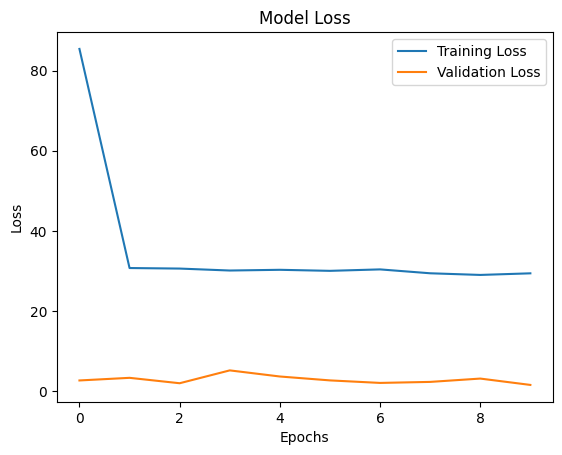

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict([X_cnn_test, X_lstm_test])



# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


56/56 [==============================] - 1s 9ms/step
Mean Squared Error: 22.72272088158859
R-squared: 0.9816982537939356


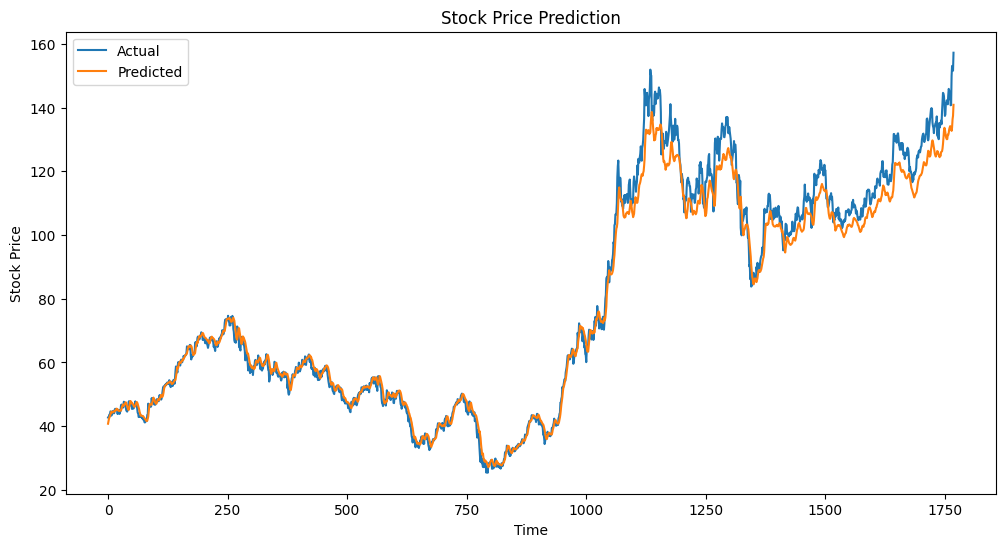

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_pred = model.predict([X_cnn_test, X_lstm_test])



mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
model.save('D:\\NIO Intern\\stock\\model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Attention, Concatenate, Flatten


sequence_length_lstm = 10

input_sequence = df['Close'].values[-sequence_length_lstm:]
input_sequence = np.reshape(input_sequence, (1, sequence_length_lstm, 1))

# Load the trained model
model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.load_weights('D:\\NIO Intern\\stock\\model.h5')

num_future_days = 30

predicted_values = []
for _ in range(num_future_days):

    predicted = model.predict([input_sequence, input_sequence])

    predicted_values.append(predicted[0][0])

    input_sequence = np.roll(input_sequence, -1, axis=1)
    input_sequence[0, -1, 0] = predicted[0, 0]

future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=num_future_days + 1, freq='B')[1:]
predicted_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': predicted_values})

predicted_df.to_csv('D:\\NIO Intern\\stock\\predicted_values.csv', index=False)

print(predicted_df)



1/1 [==============================] - 0s 22ms/step
         Date  Predicted_Close
0  2024-03-08       142.714325
1  2024-03-11       142.653320
2  2024-03-12       139.651596
3  2024-03-13       138.937988
4  2024-03-14       135.874985
5  2024-03-15       134.088150
6  2024-03-18       130.221924
7  2024-03-19       129.122528
8  2024-03-20       127.250137
9  2024-03-21       125.665703
10 2024-03-22       123.390587
11 2024-03-25       121.602417
12 2024-03-26       119.860870
13 2024-03-27       118.556656
14 2024-03-28       116.959686
15 2024-03-29       115.423363
16 2024-04-01       113.880608
17 2024-04-02       112.535393
18 2024-04-03       111.252991
19 2024-04-04       110.011070
20 2024-04-05       108.721352
21 2024-04-08       107.493523
22 2024-04-09       106.340996
23 2024-04-10       105.252151
24 2024-04-11       104.181625
25 2024-04-12       103.128822
26 2024-04-15       102.101105
27 2024-04-16       101.121422
28 2024-04-17       100.183334
29 2024-04-18     